<a href="https://colab.research.google.com/github/LauJohansson/Explorifydata/blob/master/Public_schools_etnicity_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Motivation

In general, we have been puzzled, when media outlets and politicians look at a specific statistic regarding Danish citizens with foreign backgrounds typically where the group is over-represented in some non-desirable way, but do not attempt to look for other explanation than ethnicity when trying to explain a phenomenon. We therefore wanted to look into one of the reccuring themes we have seen over the years, which is that there is a relationship between the share of students from foreign backgrounds and the performance of the school. 

### *What is your dataset?* 

Our dataset describes school performance (based on a calculated metric using grade point average and average well-being) for schools in the municipality of Copenhagen. It also ecompasses data about the institutions, and socio-economic data about the school districts. <br> 
<br>
### *Why did you choose this/these particular dataset(s)?* <br>
The dataset explained our problem of interest which is the effect (or lack thereof) of a higher share of students from foreign backgrounds on school performance. We knew about the data that The Ministry of Education keeps in their publicly open data warehouse, and we found that this was a trustworthy source of information.<br>
<br>
### *What was your goal for the end user's experience?*<br>
We hope to show the end user, that only looking at the bivariate relations between share of students with a foreign background and school perforamnce is an misleading oversimplification. We also hope to install a critical approach in our readers which could lead them to quesiton the apparent relations being presented to them, and look for alternative explanations. 

#2. Basic stats

## Imports

In [0]:
import pandas as pd
import numpy as np
import math

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.plotting import figure, output_file, save, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool, ColorBar, Tabs, Panel
from bokeh.models import Whisker, Span, Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LinearColorMapper
from bokeh.io import show, output_notebook, output_file
from bokeh.layouts import layout, column
from bokeh.transform import linear_cmap
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.palettes import brewer, viridis, Spectral6
output_notebook()

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df=pd.read_csv("/content/drive/My Drive/Social dataanalyse + viz/Social data analysis and visualization/Final assignment/BerigelseKBH.csv",delimiter=",")

## Data preparation

Several data sources with filetypes including .shp, .csv and .xlsx. have been prepared and combined in order to reach the final dataset we have worked with. Almost everything is processed in the software Alteryx, and thus, it cannot be included in this workbook. However, the following section will aim at explaining the steps taken towards the final clean data set including illustrations of the workflow.

We were able to obtain data from a range of publicly available sources, such as OpenData.dk [6], The Ministry of Education [2][3] and a non-publicly available source Folkekirkens Nødhjælp.

With this we had data describing socio-economic data on municipality, zip code and parish level for the whole country. The most granular level obtained is parish level, so this is what we used for further analysis. Also, we had data related to districts in Copenhagen and schools in some data sets for all of Denmark. 

Copenhagen is the city we all know the best and therefore expected to best be able to relate to throughout the project. Also this was the area we found most data for and thus, naturally, the area where we could be most convincing.

Unfortunately, no socio-economic data on school district level was available, so in order to approximate representative data, weighted values were calculated for each school district based on the proportional overlap of districts and parishes.

First, spatial objects were generated from a file with parish data and combined with a .shp file containing school districts to get overlaps as new spatial objects. Next, the area of each of the three special objects was calculated to derive the proportion of each overlap, e.g. how much parish 1 overlaps with school district 1 and vice versa. The output was both exported as .shp to generate maps in python and brought further in the workflow. 


![alt text](https://drive.google.com/uc?id=1QErvFnpgQ5jDR2VXzzuQaBQBDn9rvb4_)

The next data source is from Folkekirkens Nødhjælp with key socio-economic data on every parish in Denmark. The first step here was to filter parishes to only include municipalities in the Copenhagen area and to correct discrepancies in parish names between aforementioned dataset and this one as their respective ID’s did not match.

![alt text](https://drive.google.com/uc?id=1B2dLqQRoq_9cZgOypR7XKmbUgx1HyWHC)

Next, the two datasets are joined and the proportions calculated before are used to get weighted socio-economic data on school district level.

![alt text](https://drive.google.com/uc?id=1y5GExfg6KPYverSIm1em-5uzb0kiQnJT)

So far, the proces looks like this:

![alt text](https://drive.google.com/uc?id=13RmcIFUABumXMtjUoTvU4T8JXa8mvX3l)

Then, the three different files with school related data including grades, pupils’ well-being, school size, links to their websites, latitude and longitude, etc. are joined with the rest of the data in a number of steps as there are discrepancies in names and missing data in the data sets.


Finally, three new variables are generated with feature engineering. Share of foreign pupils = the sum of immigrants and descendants; Education score = the amount of years the highest educated parent has after primary school on average; Performance = the sum of standardized values for results from mandatory tests and avg. well-being among pupils.

![alt text](https://drive.google.com/uc?id=1AGzPQwhmO7mUjqwBykCoUkIA3__Qq_UP)

In the process, we decided to do some feature engineering to get the data to better fit our purpose.

The dataset includes the level of education defined in six different variables indicating the share of most well educated parents's highest finished level of education accross 6 levels. Below is a correlation matrix of them all and the variable they were ultimately combined into, *Education score*.

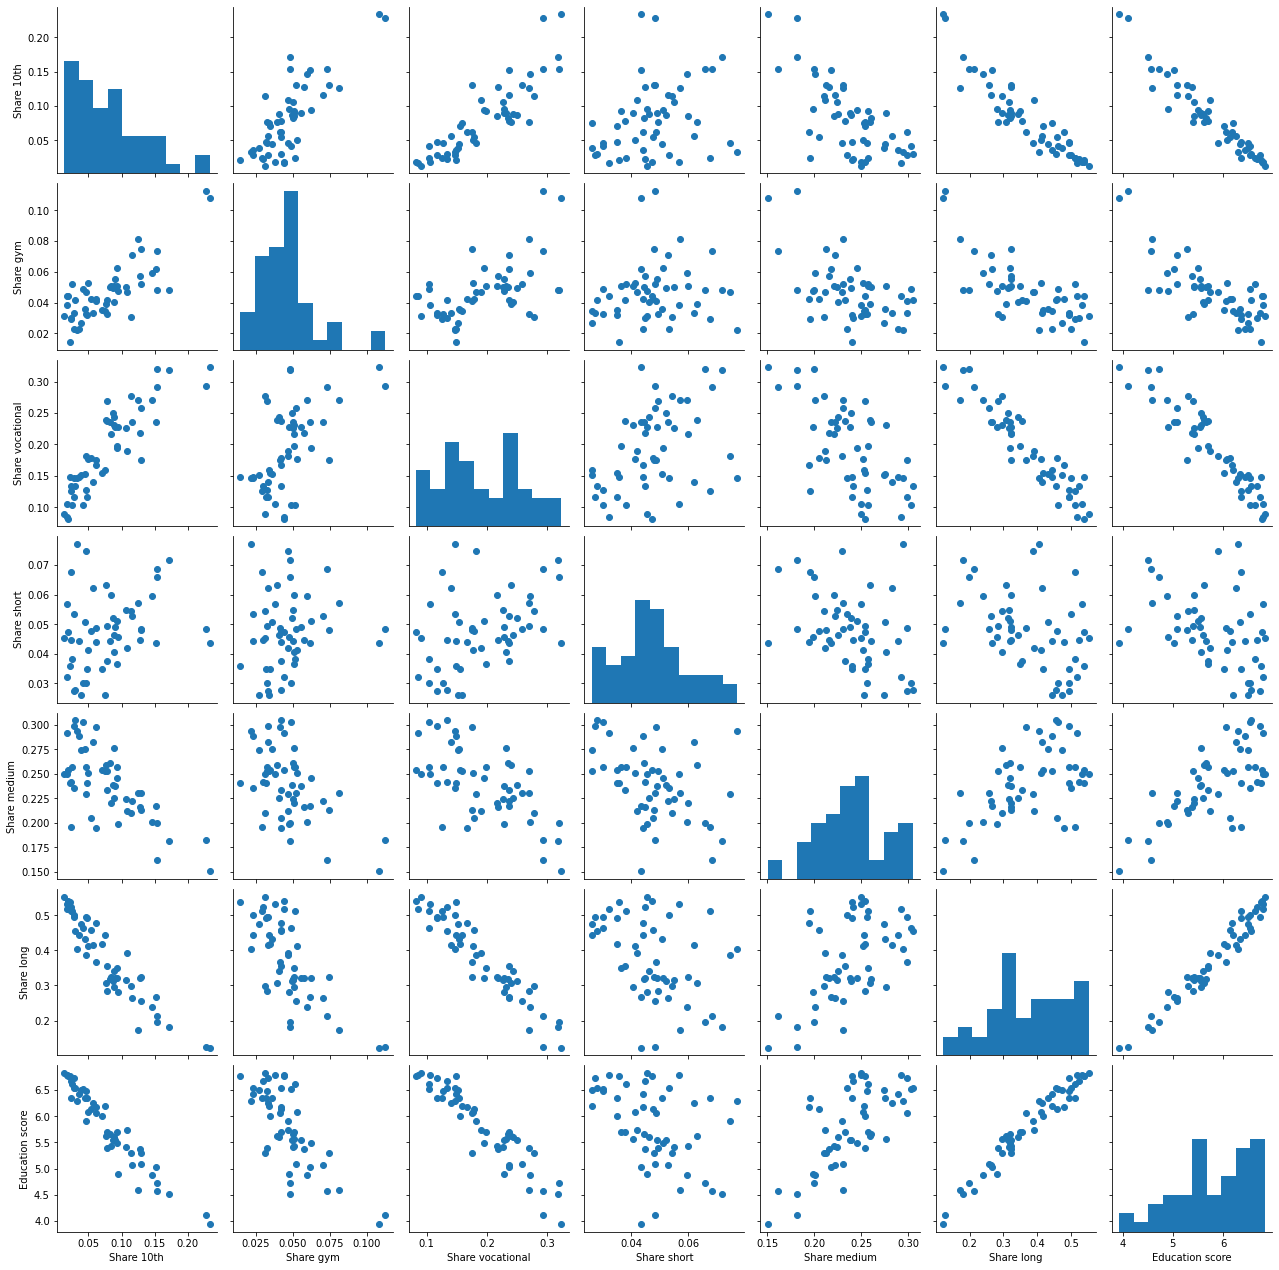

In [0]:
df1=df[['Share 10th', 
'Share gym',
'Share vocational',
'Share short',
'Share medium',
'Share long','Education score']]

g=sns.PairGrid(df1.select_dtypes(include="number"))
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

It is clear that these variables are not entirely independent of each other, since the total share is almost = 1, only excluding the share that only finished primary school. In most cases this accounts for less than 2% of the most well educated parents. 

Therefore, we decided to combine these in a single variable indicating the number of years the most well educated parents continued after primary school.<br>
<br>

Also, the data set contains *Share immigrants* and *Share descendants*. These are combined in a common variable *Share foreign*, as we do not wish to distinguish between the two groups. Finally, we calculated the unemployment rate based on the number of people of age 16+ and the total number of unemployed in the district.

That leaves us with fewer variables which fit our purpose better. Below is a correlation matrix of the final data set.

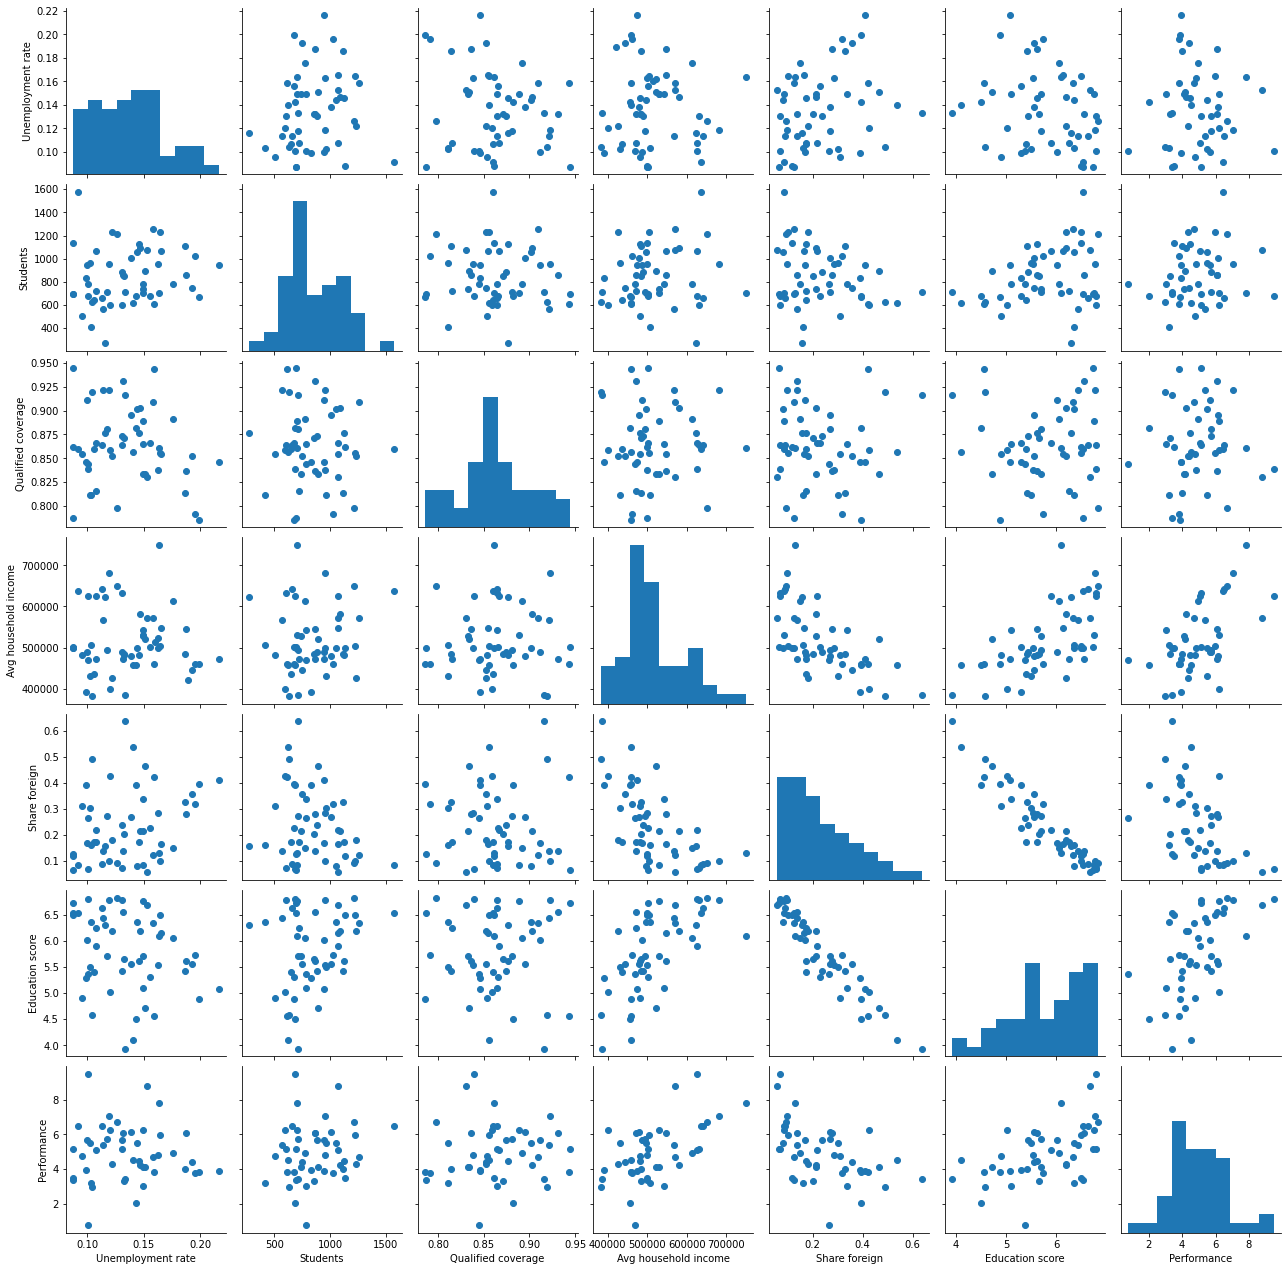

In [0]:
df2 = df[[
 'Unemployment rate',
 'Students',
 'Qualified coverage',
 'Avg household income',
 'Share foreign',
 'Education score',
 'Performance']]

g=sns.PairGrid(df2.select_dtypes(include="number"))
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

It appears that the share of pupils with a foreign background have a strong negative correlation with education score and some negative correlation with average household income. At the same time, it looks as if there is a slight positive correlation between the same two variables and school performance. This confirmes that there might be other socio-economic factors that are significant in determining the performance of the local school than the share of foreigners.

This final dataset then contains socio-economic data on each school district and thus on the pupils of each public school in Copenhagen as well as detailed data on the individual schools including among others competency level of the teacher staff, parents’ level of education and number of pupils.



---


In [0]:
# Adding helping variables to nicefy hover tooltip
df['Income_string']=df['Avg household income'].apply(lambda x: '{:,}'.format(x)+'DKK')
df['Avg household income']=df['Avg household income'].replace(float('nan'),"NAN")

df['Share foreign_percent']=df['Share foreign']*100
df['Share foreign_percent_string']=df['Share foreign_percent'].apply(lambda x: str(int(x))+'%' if not math.isnan(x) else x)

df['Performance']=np.round(df['Performance'].astype(float),decimals=1)
df['Performance_edit']=df['Performance'].replace(float('nan'),"NAN")
df['Performance_edit_string']=df['Performance_edit'].astype(str)

df['Education score']=np.round(df['Education score'].astype(float),decimals=1)
df['Education score_edit']=df['Education score'].replace(float('nan'),"NAN")
df['Education score_edit_string']=df['Education score_edit'].astype(str)

In [0]:
#Adding all variables to the source
source = ColumnDataSource(data={
    
    'School name'               : df['School name'],   
    'School ID'                 : df['School ID'],
    'Unemployment rate'         : df['Unemployment rate'],
    'Avg household income'      : df['Avg household income'],
    'Home page'                 : df['Home page'],
    'Students'                  : df['Students'],
    'Qualified coverage'        : df['Qualified coverage'],
    'Share foreign'             : df['Share foreign'],
    'DistriktID'                : df['DistriktID'],
    'lon'                       : df['lon'],
    'lat'                       : df['lat'],
    'Performance'               : df['Performance'],
    'Education score'           : df['Education score'],
    
    'sizeInc'                   : df['Avg household income']/min(df['Avg household income'])/100,
    'sizeEdu'                   :(df['Education score']**1)/(min(df['Education score'])**1)/100,
    'income_string'             : df['Income_string'],
    'Share foreign_percent_string' : df['Share foreign_percent_string'],
    'Performance_edit_string'   : df['Performance_edit_string'],
    'Education score_edit_string'  : df['Education score_edit_string']
})

#3. Data analysis

During the project's initial phase, when looking for data to validate the planned narrative, we learning that the borders school districts are in fact defined and redefined constantly to account for shifting demographics. Both in terms of number of school children but in particular also in terms of the share of pupils with foreign backgrounds. We were surprised that this was a driving mechanism, instead of other socio-economic factors such as household income. Also, according to foreign studies [4] the average household income is changing according to the performance of schools as more wealthy families have better opportunities to choose residence based on the local public school.

It was only in the later stages of the project that we concluded that GPA was not necessarily the best way to meassure the performance of a school, so we found some data describing pupils' well-being and made a metric combining the two.

### *Describe your data analysis and explain what you've learned about the dataset*<br>

We have gone from looking at the bivariate relationship between share of students with a foreign background and school performance, to a more nuanced model where variables on the institution level and variable regarding socio-economic conditions in the school districts are also included. By expanding the model in this way, we have learned that variables on the socio-economic level, specifically average household income and parents educational score, have much higher explanatory power than share of students with foreign background. Actually, when including these in the model, the effect goes from negative and significant to insignificant (and positve).<br>

From our maps we have learned about the distribution of the different variables across Copenhagen. Schools districs located in the city center generally perform better, have higher household incomes, higher levels of education and lower levels of students with foreign backgrounds. School districs in the north (Nordvest and Nørrebro) and in the south (Sydhavnen and Valby) perform worse, have lower household incomes, lower levels of education and higher levels of students with foreign backgrounds. This supported our expectation of the distribution in Copenhagen. What did surprise us, though, was the disparity between the richest and the poorest school districts, which is approximately a factor of 2, between Grøndalsvænget School (poorest, 382,152 DKK) and Nyboder School (richest, 750,569 DKK).<br>


### *If relevant, talk about your machine-learning.*

To test our hypothesis, that other factors than ethnicity explain a large portion of school performance, and that share of students from foreign background might not have an impact at all, when accounting for these other factors. So we ran a simple linear regression model on the dataset of public schools in Copenhagen, with one independent variale: Share of student with foreign backgrounds, and the dependent variable: School performance (calculated as shown above). The simple model supported the claim that schools with more students from foreign backgrounds perform worse. We then tested the strength of this relation, by first adding variables regarding the school and then informaiton about the socio-economic conditions in the school district. The three models were the following:<br>
<br>
**Model 1 (Ethnicity)**
- Share of students from foreign background

This model is used as a baseline, showing the simplistic dynamics of school performance that we are trying to challenge.<br>
<br>
**Model 2 (Ethnicity + Institutional)**
- Share of students from foreign background
- Number of students attending the school
- Qualified coverage

Maybe the number of students affect the performance? Students might feel "lost" at some the bigger schools. The level of qualified coverage could also affect the performance, in the sense that higher levels of qualified coverage should lead to higher grades and happier kids. <br>
<br>
**Model 3 (Ethnicity + Institutional + Socio-economic)**
- Share of students from foreign background
- Number of students attending the school
- Qualified coverage
- Unemployment rate
- Average household income
- Education score

High levels of unemployment, low average household income and low levels of education are all expected to negatively affect the the grades and well-being in school of the students. 

**Results** <br>
As will be shown in section 5. Visualizations, the results of running the models were along the lines of what we expected. Variables about the schools didn't explain school performance, **HVORFOR DET?**. On the other hand, including socio-economic factors had a big impact on the model, and the effect of share of students from foreign backgrounds became insignificant. Only average household income had a significant effect on shcool perforamnce, though education score was almost significant (and might have been if there were more datapoints). 



## 3 regression models

In [0]:
data = pd.read_csv('/content/drive/My Drive/Social data analysis and visualization/BerigelseKBH.csv') 


### Model 1

In [0]:
# Model with just share of students with foreign background

# drop NaNs
df = data.dropna()

# standardize X and add constant
X1=df[['Share foreign']]
X1=preprocessing.scale(X1)
X1=pd.DataFrame.from_records(X1) # this ensures that it keeps the var-names
X1.columns=['Share foreign'] # this ensures that it keeps the var-names
X1=sm.add_constant(X1) 

y = df["Performance"].values # .values removes the index, so they are aligned

# estimate model 
model1 = sm.OLS(y, X1).fit() 
predictions1 = model1.predict(X1)

# Print out the statistics
model1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     14.05
Date:                Thu, 14 May 2020   Prob (F-statistic):           0.000526
Time:                        09:39:33   Log-Likelihood:                -75.884
No. Observations:                  45   AIC:                             155.8
Df Residuals:                      43   BIC:                             159.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8535      0.199     24.360      0.000       4.452       5.255
Share foreign    -0.7469      0.199     -3.749      0.001      -1.149      -0.345
==============================================================================
Omnibus:                        4.151   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                4.147
Skew:                          -0.128   Prob(JB):                        0.126
Kurtosis:                       4.465   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 2

In [0]:

## Now with independent variables added on institutional level ## 

# drop NaNs
df = data.dropna()

# standardize X and add constant
X2=df[['Share foreign','Students','Qualified coverage']]
X2=preprocessing.scale(X2)
X2=pd.DataFrame.from_records(X2) # this ensures that it keeps the var-names
X2.columns=['Share foreign','Students','Qualified coverage'] # this ensures that it keeps the var-names
X2=sm.add_constant(X2) 

y = df["Performance"].values # .values removes the index, so they are aligned

# estimate model 
model2 = sm.OLS(y, X2).fit() 
predictions2 = model2.predict(X2)

# Print out the statistics
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     4.836
Date:                Thu, 14 May 2020   Prob (F-statistic):            0.00567
Time:                        09:39:40   Log-Likelihood:                -75.429
No. Observations:                  45   AIC:                             158.9
Df Residuals:                      41   BIC:                             166.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.8535      0.202     24.028      0.000       4.446       5.261
Share foreign         -0.7989      0.213     -3.750      0.001      -1.229      -0.369
Students              -0.1890      0.214     -0.884      0.382      -0.621       0.243
Qualified coverage     0.0164      0.206      0.079      0.937      -0.400       0.433
==============================================================================
Omnibus:                        4.542   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.229
Skew:                          -0.291   Prob(JB):                        0.121
Kurtosis:                       4.385   Cond. No.                         1.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3

In [0]:
## Now with independent variables added on socio-economic level ## 

# drop NaNs
df = data.dropna()

# standardize X and add constant
X3=df[['Share foreign',
      'Students',
      'Qualified coverage','Unemployment rate','Avg household income',
      'Education score']]
X3=preprocessing.scale(X3)
X3=pd.DataFrame.from_records(X3) # this ensures that it keeps the var-names
X3.columns=['Share foreign',
           'Students',
           'Qualified coverage','Unemployment rate','Avg household income',
           'Education score'] # this ensures that it keeps the var-names
X3=sm.add_constant(X3) 

y = df["Performance"].values # .values removes the index, so they are aligned

# estimate model 
model3 = sm.OLS(y, X3).fit() 
predictions3 = model3.predict(X3)

# Print out the statistics
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     4.299
Date:                Thu, 14 May 2020   Prob (F-statistic):            0.00211
Time:                        09:39:43   Log-Likelihood:                -70.589
No. Observations:                  45   AIC:                             155.2
Df Residuals:                      38   BIC:                             167.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8535      0.188     25.759      0.000       4.472       5.235
Share foreign            0.7200      0.667      1.080      0.287      -0.629       2.069
Students                -0.1673      0.214     -0.783      0.439      -0.600       0.265
Qualified coverage       0.0986      0.197      0.501      0.619      -0.300       0.497
Unemployment rate        0.0288      0.215      0.134      0.894      -0.407       0.464
Avg household income     0.5697      0.260      2.190      0.035       0.043       1.096
Education score          1.2020      0.643      1.869      0.069      -0.100       2.504
==============================================================================
Omnibus:                        1.399   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                0.589
Skew:                          -0.030   Prob(JB):                        0.745
Kurtosis:                       3.557   Cond. No.                         7.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We note that the adjusted R-squared falls slightly between Model 1 and Model 2, and then jumps quite significantly between Model 2 and Model 3 - ending at 0.310, which is acceptable for a problem from the more societal domain. So we feel confident with moving on to the plots.

#4. Genre



###*Which genre of data story did you use?*

Our narrative visualization is a mix of ***annotated graphs/maps*** within a ***slideshow format***. Overall, we follow a ***martini glass*** structure where the two linear elements to begin with (scatterplot and regression visualization) followed by a map with a more user directed path.

###*Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?*


**Visual structuring:** In the maps of Copenhagen we use a ***consistent visual platform***, where the graphical layout of Copenhagen remains the same, while each feature is given a distinct colouring scheme that represents low/high levels of the given feature. This is done ease transition between features, but also confirm that a change has taken place.<br>
<br> 
**Highlighting:** In the scatterplot we use ***feature distinction*** to show first just the relationship between school performance and share of students with foreign background, then we add average household income through colours and finally education score through size of the dots. By adding features to the same plot, but through distinct ways, we hope to create a feeling of a gradually changing interpretation. From confirming the claim of a strong relationship between school performance and share of students with foreign backgrounds, to a feeling of uncertainty since the added variable also appear to be very correlated with school performance.<br>
<br> 
**Transition guidance:** Here we use ***object continuity***. For example, in the plot of coefficients for share of students with foreign background from all three models, the coefficients within Model 3 are coloured green – while all coefficients in the next plot (showing entire Model 3) are also coloured green. The colours are also used in the accompanying text. If the reader is unfamiliar with linear regression, then it is easy to lose one’s way in this section. So, maintaining some continuity in the use of colours hopefully can help guide the reader through this part.

###*Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?*

**Ordering:** The scatterplot and regression coefficient of share foreign visualizations have tabs on them direct the reader along an author driven ***linear path*** much like a slideshow. The visualization with multiple maps (also using tabs) is more reader driven and allows a ***user directed path***, since the maps are do not show anything evolving, but just the distribution of relevant variables across Copenhagen. Using a linear path allows us to communicate a specific message, while the user directed path hopefully engages the reader more and speaks towards his/her curiosity.<br>
<br>
**Interactivity:** All of our plots have ***hover highlighting*** with details-on-demand. Our plots with tabs (scatterplot, first plot of model regression coefficients and final model of maps) have ***navigation buttons*** that enables moving from tab to tab at the reader own pace. The details-on-demand in for example the maps cater to the different attitudes of readers: some might just want to look at the overall distribution in Copenhagen, while others might want to know the specific levels in a set of school districts.<br>
<br>  
**Messaging:** Our narrative visualization uses a lot of the elements in this category, but most distinctive would be that the visualizations have an ***accompanying article*** that sets up the intended interpretation of the plots. In this project, we are trying to communicate something very specific and slightly complicated: that it is an oversimplification when media and politicians look at the bivariate relation between share of students with foreign backgrounds and school performance. So, the accompanying article lets us set the stage for the visualizations and comment on what they mean afterwards. Specially the visualizations of linear regression coefficients would be impossible to communicate to a non-technical reader without the accompanying article.

#5. Visualizations


## **Scatter plot**<br>
### *Explain the visualizations you've chosen.*
First the reader is presented with a scatterplot with three tabs. The first tab shows the relationship between share of foreign pupils and the performance of schools. The two other tabs each add another dimension to the plot. Thus, the second tab includes the average household income in the school district on a color scale from light blue to dark blue as lowest to highest. The last tab adds education score as the size of the circles. Moreover, annotations are added to the two latter tabs to draw attention to the point being made. Ultimately, the plot includes 4 dimensions in a simple and universally understandable way.

### *Why are they right for the story you want to tell?*
The scatter plot is a simple plot that everyone is familiar with and it is clear to see that it appears that the popular opinion is true, i.e. that the two variables are negatively correlated. However, when prompted to browse through the tabs, more information is added to the same plot showing that there are other factors influencing the case. The intended effect is that the viewer will first see the plot and be confirmed in their inherited bias. Each new click should then *wow* the viewer making them receptible for the rest of the narrative. <br> <br>

## **Visualizing linear regression models** <br>

### *Explain the visualizations you've chosen.*
**Coefficients of share foreign in the three models**<br>
We wanted to test our belief that share of students from foreign backgrounds actually doesn't explain the performance of the school, if one is to account for more variables than just share of foreign students. Furthermore, we would like to show the result of this test, in a visual way, to our reader. So we ran the three regression models, and extract the coefficients and confidence intervals for share of foreign student from each model.<br>

The coefficients of share of foreign students are then plotted together from all three models along with whiskers that indicate the 95-pct. confidence intervals.<br> 

We hope (and anticipate) that the coefficient will go from being negative and significant to being insignificant. This will show the reader that it is an oversimplification just to look at share of foreign students and school performance, and then infer that schools with higher shares of  student from foreign background perform worse.<br>
We place the coefficient of share of students with foreign backgrounds on tabs in the top of the plot, so the reader can "discover" the effect of adding varialbes to the model.   

**Coefficients of Model 3 (Ethnicity + Institutional + Socio-economic)**<br>
The coefficients of all variables in Model 3 are plotted along with whiskers that indicate the 95-pct. confidence intervals.<br> 

**Fake coefficients of a weight-loss model**<br>
We create some fake data about coefficient for a hypothetic weight-loss model and plot the coefficients and 95-pct. confidence intervals in the same way as for Model 3. 

### *Why are they right for the story you want to tell?*
**Coefficients of share foreign in the three models**<br>
We want to convince readers that only looking at share of student with foreign backgrounds is an oversimplification, or simply confirm their beliefs. So only plotting the coefficient for share of students with foreign backgrounds lets the reader focus entirely on the effect of that specific variable. Arranging it in tabs, so the reader can be the one who "discovers" the truth, should hopefully add a little exitement, but also encode it better in the long term memory of the reader, since they are activated more than simply just looking at the plot. 

**Coefficients of Model 3 (Ethnicity + Institutional + Socio-economic)**<br>
Now that we - hopefully - have convinced the reader that looking only at etnicity is too simple, the reader can dive into a plot of what actually does affect school performance. This plot answers the obvious question which is "if not ethnicity, then what explains school performance". So this plot naturally follows the narrative line drawn by the scatter plot which creates uncertainty about the bivariate relationship, then the plot with coefficients of share foreign that disprove the bivariate relationship, and then nuances the understanding of the dynamics behind school performance with variables that better explains it.  

**Fake coefficients of a weight-loss model**<br>
When explaining the findings in the plots, we felt it was necessary to give the reader a short crash course about linear regression. So this toy-example plot is meant as a visual aid towards that goal.  <br> <br>

## **Mapping schooldistricts** <br>
### *Explain the visualization you've chosen*<br>
Making interactive maps of the school districts in Copenhagen emphasizes a more reader-driven narrative. The reader has the oppurtunity to explore specific districts which is in the interests of the reader.  The variables to be visualized on the maps has from an author-driven perspective been selected deliberately. That means, the reader can only interact with the variables (Share of foreign, Income, education score and performance) which fits the narrative of the project. Maps gives an intuitive representation of spatial data, which in this case is data on the districts (polygons).  The maps also provides the possibility to compare values between the districts and thereby e.g. compare performances of different schools districts. The hover function to present data makes it easy for the reader to locate a district visually and just move the mouse to the specific district. The maps are choropleth maps where the districts are colored in proportion to e.g socioeconomic variables. Choropleth maps makes it easy for the reader to identify school districts that is associated with high (dark colors) or low (bright colors) values of the specific variable.

### *Why are they right for the story you want to tell?* <br>
The project examines the relation between school performances and socioeconomic variables related to the school district. School districts are geospatial data, and since geospatial data can be represented in a map, they are obvious to be choosen as visualization tool. The maps will stand in contrast to the regression models, which are represented in a "classical" coordinate system. To catch the non-technical reader's attention it is important to make use of visualizations that are well known. Although the maps are basically coordinates (longitudes and latitude), we expect the reader to find maps very intuitive to use, as most people use maps in their everyday lives (e.g. GPS in the car).





## Scatter plots 



In this section, the explorer is guided through some of the main points of the narrative by an invition to interact with a scatterplot to reveal hidden and often not mentioned dependencies to school performance. 

A selection of scatterplots is made, to enable the explorer to see the relationship between some of the variables against school performance and share of foreigners pr school. 

Through each of the following three cells, a plot is generated adding a new dimension to it in each cell and all three are displayed together in different tabs in the last cell.

The selected variables are 'Avg household income' and 'Education score' as these are expected to be interesting for a broard audience and fit well with the planned narative of the explanatory data analysis.

In [0]:
palette = brewer['PuBu'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

radii = 0.01 #Size of initial scatters
TOOLS="wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset"

# Defining x and y axes
x = 'Share foreign'
y = 'Performance'

In [0]:
radii = 0.01 #Size of scatters

p0 = figure(tools=TOOLS)

Schools = p0.circle(x, y, radius=radii, fill_alpha=0.6, fill_color=palette[3], line_color='grey', source=source)

### Axis labels
p0.xaxis.axis_label = "% of foreigners"
p0.xaxis[0].formatter = NumeralTickFormatter(format="0.0%")
p0.yaxis.axis_label = "School performance"


### Create hover tool ###
p0.add_tools(HoverTool(renderers = [Schools],
                      tooltips = [('School','@{School name}'),
                                  ('Share of foreigners', '@{Share foreign_percent_string}'),
                                  ('Performance','@Performance_edit_string')]))

###
citation1 = Label(x=0.2, y=8,# x_units='screen', y_units='screen',
                 text='  Try adding dimensions using these tabs!  ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 
p0.add_layout(citation1)


# add arrows
p0.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                 x_start=0.35, y_start=8.3, x_end=0.4, y_end=9.5))

p0.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=0.35, y_start=8.3, x_end=0.57, y_end=9.5))

###

p0.xgrid.grid_line_color = None
p0.ygrid.grid_line_color = None

tabscat0 = Panel(child=p0, title="Foreigners vs. School performance")

In [0]:
z = 'Avg household income'
radii = 0.01
    
p1 = figure(tools=TOOLS)

# The value of Avg household income defines the color of data points
colors = linear_cmap(field_name=z, palette=palette, low=min(df[z]), high=max(df[z]))

color_mapper = LinearColorMapper(palette = palette, low = min(df[z]), high = max(df[z]),nan_color='grey')

# Define custom tick labels for color bar.
tick_labels = {400000: '400k', 450000: '450k',
 500000:'500k', 550000:'550k',
 600000:'600k', 650000:'650k',
 700000:'700k', 750000:'750k'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 20, height = 550,
                     border_line_color = None,
                     location = (0,-20),
                     orientation = 'vertical',
                     major_label_overrides = tick_labels)

p1.add_layout(color_bar, 'right')


# Set autohide to true to only show the toolbar when mouse is over plot
#p1.toolbar.autohide = True

Schools = p1.circle(x, y, radius=radii, fill_alpha=0.75, fill_color=colors, line_color='grey', source=source)

### Axis labels
p1.xaxis.axis_label = "% of foreigners"
p1.xaxis[0].formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "School performance"


### Create hover tool ###
p1.add_tools(HoverTool(renderers = [Schools],
                      tooltips = [('School','@{School name}'),
                                  ('Share of foreigners', '@{Share foreign_percent_string}'),
                                  ('Performance', '@Performance_edit_string'),
                                  ('Avg household income', '@income_string')]))

p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

###
### add annotation (citations)
 
citation1 = Label(x=0.4, y=7,# x_units='screen', y_units='screen',
                 text='  Notice any difference?  ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 
citation2 = Label(x=0.11, y=8,# x_units='screen', y_units='screen',
                 text=' Dark ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 

citation3 = Label(x=0.62, y=2.8,# x_units='screen', y_units='screen',
                 text=' Light ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 
p1.add_layout(citation1)
p1.add_layout(citation2)
p1.add_layout(citation3)
 

# add arrows
p1.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=0.48, y_start=7.3, x_end=0.17, y_end=7.8))

p1.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=0.5, y_start=7.2, x_end=0.625, y_end=3.7))

###

tabscat1 = Panel(child=p1, title="Add dimension income as color")

In [0]:
w = 'Education score'

# Value of Education score defines size of data points
radii = 'sizeEdu'

p2 = figure(tools=TOOLS)

p2.add_layout(color_bar, 'right')

# Set autohide to true to only show the toolbar when mouse is over plot
#p2.toolbar.autohide = True

#Schools = p2.circle(x=x, y=y, radius=radii, fill_alpha=0.75, fill_color=colors, line_color='grey', source=source)
p2.circle(x=x, y=y, radius=radii, fill_alpha=0.75, fill_color=colors, line_color='grey', source=source)

### Axis labels
p2.xaxis.axis_label = "% of foreigners"
p2.xaxis[0].formatter = NumeralTickFormatter(format="0.0%")
p2.yaxis.axis_label = "School performance"


### Create hover tool ###
p2.add_tools(HoverTool(
                      tooltips = [('School','@{School name}'),
                                  ('Share of foreigners', '@{Share foreign_percent_string}'),
                                  ('Performance','@Performance_edit_string'),
                                  ('Avg household income', '@{income_string}'),
                                  ('Education score','@{Education score_edit_string}'),
                                  ('(x, y)', '($x, $y)'),
                                  ('(sx, sy)', '($sx, $sy)')],
                      point_policy='snap_to_data',
                      show_arrow=True,
                      mode='mouse'))
        
p2.xgrid.grid_line_color = None
p2.ygrid.grid_line_color = None


###
### add annotation (citations)
citation1 = Label(x=0.4, y=7,# x_units='screen', y_units='screen',
                 text='  Notice any difference?  ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 
citation2 = Label(x=0.1, y=9.35,# x_units='screen', y_units='screen',
                 text=' Big ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 

citation3 = Label(x=0.62, y=2.8,# x_units='screen', y_units='screen',
                 text=' Small ', render_mode='css',
                 border_line_color='black', border_line_alpha=0.7,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='10pt')
 
p2.add_layout(citation1)
p2.add_layout(citation2)
p2.add_layout(citation3)
 

# add arrows
p2.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                 x_start=0.48, y_start=7.3, x_end=0.105, y_end=9.25))

p2.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=0.5, y_start=7.2, x_end=0.625, y_end=3.7))

###

tabscat2 = Panel(child=p2, title="Add dimension education score as size")

tabscatter = Tabs(tabs=[tabscat0, tabscat1, tabscat2],sizing_mode="stretch_width")

show(tabscatter)

outfp = r"scatterHTML.html"
save(tabscatter, outfp)

Note that unfortunately it is now yet possible in Bokeh to include a legend for circle size.

## Visualizations of the linear regression models

Loading the data

In [0]:
data = pd.read_csv('/content/drive/My Drive/Social data analysis and visualization/BerigelseKBH.csv') 

### Create data for plot #1

In [0]:

# plug in the relevant information from the model output that is needed to create the plot

# var: name of the variable
# coeff: coefficient of the variable
# mod: declaring which model it is (1,2,3)
# err: the width of the whiskers (95-pct. confidence interval)
# idx: controls where the bar is placed on the y-axis
# idxh: controls the top of the vertical ends of the whiskers
# idxl: controls the bottom of the vertical ends of the whiskers
# low: lowest end of the 95-pct. confidence interval
# high: highest end of the 95-pct. confidence interval


data = [[X3.columns[1]+'3',model3.params[1],'mod3',abs(model3.conf_int().values[1][0]-model3.conf_int().values[1][1]),0.5,0.55,0.45,model3.conf_int().values[1][0],model3.conf_int().values[1][1]],
        [X2.columns[1]+'2',model2.params[1],'mod2',abs(model2.conf_int().values[1][0]-model2.conf_int().values[1][1]),1.5,1.55,1.45,model2.conf_int().values[1][0],model2.conf_int().values[1][1]],
        [X1.columns[1]+'1',model1.params[1],'mod1',abs(model1.conf_int().values[1][0]-model1.conf_int().values[1][1]),2.5,2.55,2.45,model1.conf_int().values[1][0],model1.conf_int().values[1][1]]]

df = pd.DataFrame(data)
df.columns = ['var','coeff','mod','err','idx','idxh','idxl','low','high'] 
df


,var,coeff,mod,err,idx,idxh,idxl,low,high
0,Share foreign3,0.719997,mod3,2.698937,0.5,0.55,0.45,-0.629471,2.069466
1,Share foreign2,-0.798886,mod2,0.860551,1.5,1.55,1.45,-1.229161,-0.368610
2,Share foreign1,-0.746877,mod1,0.803620,2.5,2.55,2.45,-1.148687,-0.345067


### Plot #1 with change in share of foreign students

In [0]:
### TAB 1 ###

plot1 = figure(title='Coefficients of share of students with foreign background',
          x_axis_label='Coefficient', # name of x-axis
          y_axis_label='Variable', #name of y-axis #fjern ) + #
          y_range=df['var'],
          x_range=(-2.25,2.25))# plotting on var axis # udkommenter for var-akse på idx plot

#x_range.set({"start": -1, "end": 1})
    
models1=[df[(df['mod']=='mod1')&(df['var']==X1.columns[1]+'1')]]

names1=['Model 1']

colors1=['#3288bd']

for model, name, color in zip(models1,names1,colors1):
    
    dfp=model    
        
    plot1.rect('coeff', # plotting idx data
              'idx',
              width='err', 
              height=0.005,
              color=color,
              legend=name,
              source=dfp)
    
    plot1.circle('coeff', # plotting idx data
              'idx',
              color=color,
              size=12,
              legend=name,
              source=dfp)
    
    plot1.segment(x0='low', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='low',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)
    
    plot1.segment(x0='high', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='high',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)

# add annotation (citations)

citation = Label(x=240, y=380, x_units='screen', y_units='screen',
                 text='In Model 1, share foreign is significant.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='7.4pt')

plot1.add_layout(citation)


# add arrows
plot1.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=0.2, y_start=2.2, x_end=-0.60, y_end=2.45))
    

    
# add horizontal line
vline = Span(location=0, dimension='height', line_color='black', line_width=2)
plot1.renderers.extend([vline])

# add tooltips + add var name permanently on! 
hover = HoverTool(tooltips=[('Variable', '@var'),('Coefficient', '@coeff')])
plot1.add_tools(hover)

plot1.legend.location = "top_right"

tab1 = Panel(child=plot1, title="Ethnicity") 


### TAB 2 ###

plot2 = figure(title='Coefficients of share of students with foreign background',
          x_axis_label='Coefficient', # name of x-axis
          y_axis_label='Variable', #name of y-axis 
          y_range=df['var'],
          x_range=(-2.25,2.25))


models2=[df[(df['mod']=='mod1')&(df['var']==X1.columns[1]+'1')],
        df[(df['mod']=='mod2')&(df['var']==X2.columns[1]+'2')]]

names2=['Model 1', 'Model 2']

colors2=['#3288bd','#fc8d59']

for model, name, color in zip(models2,names2,colors2):
    
    dfp=model    
        
    plot2.rect('coeff',
              'idx',
              width='err', 
              height=0.005,
              color=color,
              legend=name,
              source=dfp)
    
    plot2.circle('coeff', 
              'idx',
              color=color,
              size=12,
              legend=name,
              source=dfp)
    
    plot2.segment(x0='low', 
                 y0='idxl',
                 x1='low',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)
    
    plot2.segment(x0='high', 
                 y0='idxl',
                 x1='high',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)


    
# add annotation (citations)

citation = Label(x=60, y=360, x_units='screen', y_units='screen',
                 text='In Model 2, there is no change.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='7.4pt')

plot2.add_layout(citation)


# add arrows
plot2.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=-0.9, y_start=2.1, x_end=-0.82, y_end=1.6))    
    
    
    
    

# add horizontal line
vline = Span(location=0, dimension='height', line_color='black', line_width=2)
plot2.renderers.extend([vline])

# add tooltips 
hover = HoverTool(tooltips=[('Variable', '@var'),('Coefficient', '@coeff')])
plot2.add_tools(hover)

plot2.legend.location = "top_right"

tab2 = Panel(child=plot2, title="Ethnicity + Institutional") 


### TAB 3 ###

plot3 = figure(title='Coefficients of share of students with foreign background',
          x_axis_label='Coefficient', # name of x-axis
          y_axis_label='Variable', #name of y-axis #fjern ) + #
          y_range=df['var'],
          x_range=(-2.25,2.25))# plotting on var axis # udkommenter for var-akse på idx plot


models3=[df[(df['mod']=='mod1')&(df['var']==X1.columns[1]+'1')],
        df[(df['mod']=='mod2')&(df['var']==X2.columns[1]+'2')],
        df[(df['mod']=='mod3')&(df['var']==X3.columns[1]+'3')]]

names3=['Model 1', 'Model 2', 'Model 3']

colors3=['#3288bd','#fc8d59','#99d594']

for model, name, color in zip(models3,names3,colors3):
    
    dfp=model    
        
    plot3.rect('coeff', # plotting idx data
              'idx',
              width='err', 
              height=0.005,
              color=color,
              legend=name,
              source=dfp)
    
    
    plot3.circle('coeff', # plotting idx data
              'idx',
              color=color,
              size=12,
              legend=name,
              source=dfp)
    
    plot3.segment(x0='low', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='low',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)
    
    plot3.segment(x0='high', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='high',
                 y1='idxh', 
                 color=color,
                 legend=name,
                 line_width=2,
                 source=dfp)

    

# add annotation (citations)

citation = Label(x=15, y=140, x_units='screen', y_units='screen',
                 text='In Model 3, share foreign becomes insignificant.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='7.4pt')

plot3.add_layout(citation)


# add arrows
plot3.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=-0.2, y_start=0.83, x_end=0.60, y_end=0.55))

    
# add horizontal line
vline = Span(location=0, dimension='height', line_color='black', line_width=2)
plot3.renderers.extend([vline])

# add tooltips + add var name permanently on! 
hover = HoverTool(tooltips=[('Variable', '@var'),('Coefficient', '@coeff')])
plot3.add_tools(hover)

plot3.legend.location = "top_right"

tab3 = Panel(child=plot3, title="Ethnicity + Institutional + Socio-economic")    



# collect all the tabs
tabs = Tabs(tabs=[ tab1, tab2 ,tab3 ])

# create and save HTML
htmlDAN1 = file_html(tabs, CDN, "my plot")
htmlDAN1=output_file('htmlDAN1.html')

show(tabs)


RuntimeError: ignored

### Create data for plot #2

Now we want to let the reader dive into the coefficients of all the variable that were included in model 3, and allow them to explore what variables actually do impact the performance of the schools.

In [0]:
# Same procedure as for plot #1


data = [[X3.columns[6],model3.params[6],'mod2',abs(model3.conf_int().values[6][0]-model3.conf_int().values[6][1]),0.5,0.55,0.45,model3.conf_int().values[6][0],model3.conf_int().values[6][1]],
        [X3.columns[5],model3.params[5],'mod2',abs(model3.conf_int().values[5][0]-model3.conf_int().values[5][1]),1.5,1.55,1.45,model3.conf_int().values[5][0],model3.conf_int().values[5][1]],
        [X3.columns[4],model3.params[4],'mod2',abs(model3.conf_int().values[4][0]-model3.conf_int().values[4][1]),2.5,2.55,2.45,model3.conf_int().values[4][0],model3.conf_int().values[4][1]],
        [X3.columns[3],model3.params[3],'mod2',abs(model3.conf_int().values[3][0]-model3.conf_int().values[3][1]),3.5,3.55,3.45,model3.conf_int().values[3][0],model3.conf_int().values[3][1]],
        [X3.columns[2],model3.params[2],'mod2',abs(model3.conf_int().values[2][0]-model3.conf_int().values[2][1]),4.5,4.55,4.45,model3.conf_int().values[2][0],model3.conf_int().values[2][1]],
        [X3.columns[1],model3.params[1],'mod1',abs(model3.conf_int().values[1][0]-model3.conf_int().values[1][1]),5.5,5.55,5.45,model3.conf_int().values[1][0],model3.conf_int().values[1][1]]]


df = pd.DataFrame(data)
df.columns = ['var','coeff','mod','err','idx','idxh','idxl','low','high']
df

### Plot #2 (all coefficients from Model 3)

In [0]:


from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead

source = ColumnDataSource(df)

plot = figure(title='Coefficients of Model 3 (Ethnicity + Institutional + Socio-economic)',
          x_axis_label='Coefficient', # name of x-axis
          y_axis_label='Variable', #name of y-axis #fjern ) + #
          y_range=df['var'],
          x_range=(-2.75,2.75))# plotting on var axis # udkommenter for var-akse på idx plot

plot.rect('coeff', # plotting idx data
          'idx',
          width='err', 
          height=0.005,
          color='#99d594',
          source=source)


plot.circle('coeff', # plotting idx data
              'idx',
              size=10,
              color='#99d594',
              source=source)

plot.segment(x0='low', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='low',
                 y1='idxh', 
                 line_width=2,
                 color='#99d594',
                 source=source)
    
plot.segment(x0='high', # til det sidste på de hjemmelavede whiskers.
                 y0='idxl',
                 x1='high',
                 y1='idxh', 
                 line_width=2,
                 color='#99d594',
                 source=source)

# add horizontal line
vline = Span(location=0, dimension='height', line_color='black', line_width=2)
plot.renderers.extend([vline])

# add tooltips 
hover = HoverTool(tooltips=[('Variable', '@var'),('Coefficient', '@coeff')]) 
plot.add_tools(hover)

# add annotation (citations)

citation = Label(x=12, y=160, x_units='screen', y_units='screen',
                 text='Only avg. household income is significant.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='7.4pt')

plot.add_layout(citation)

citation2 = Label(x=5, y=10, x_units='screen', y_units='screen',
                 text='Although education score is pretty close!', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=10.0, text_font_size='7.4pt')

plot.add_layout(citation2)

# add arrows
plot.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=-0.5, y_start=1.9, x_end=0.4, y_end=1.6))

plot.add_layout(Arrow(end=NormalHead(size=10,fill_color="black"),
                   x_start=-0.45, y_start=0.15, x_end=-0.15, y_end=0.4))

# create and save HTML
htmlDAN2 = file_html(plot, CDN, "my plot")
htmlDAN2=output_file('htmlDAN2.html')

show(plot)

### Create data for plot #3

This plot is created with "fake" data as a visual aid in explaining the concept behind linear regression, coefficients, confidence intervals and significance. Basically, it is a toy example that prepares the reader for the real deal. 

In [0]:
# Same procedure as for plot #1


data = [['Books read',-0.103,'mod1',0.4,0.5,0.55,0.45,-0.303,0.097],
        ['Meetings attended',0.06,'mod1',0.6,1.5,1.55,1.45,-0.24,0.36],
        ['Portions of fast food',-0.34,'mod1',0.24,2.5,2.55,2.45,-0.46,-0.22],
        ['Hours at the gym',0.54,'mod1',0.16,3.5,3.55,3.45,0.46,0.62]]


df = pd.DataFrame(data)
df.columns = ['var','coeff','mod','err','idx','idxh','idxl','low','high']
df

### Plot #3 (toy example about weight-loss)

In [0]:

source = ColumnDataSource(df)

plotF = figure(title='Fake coefficient of a weight-loss model',
          x_axis_label='Coefficient', # name of x-axis
          y_axis_label='Variable', #name of y-axis 
          y_range=df['var'],
          x_range=(-0.75,0.75))

plotF.rect('coeff', # plotting the horisontal bar that is the width of the confidence interval
          'idx',
          width='err', 
          height=0.005,
          color='#66c2a5',
          source=source)


plotF.circle('coeff', # plotting a dot at the point of the coefficient
              'idx',
              size=10,
              color='#66c2a5',
              source=source)

plotF.segment(x0='low', # vertical end of whiskers (bottom).
                 y0='idxl',
                 x1='low',
                 y1='idxh', 
                 line_width=2,
                 color='#66c2a5',
                 source=source)
    
plotF.segment(x0='high', # vertical end of whiskers (top).
                 y0='idxl',
                 x1='high',
                 y1='idxh', 
                 line_width=2,
                 color='#66c2a5',
                 source=source)

# add horizontal line
vline = Span(location=0, dimension='height', line_color='black', line_width=2)
plotF.renderers.extend([vline])

# add tooltips
hover = HoverTool(tooltips=[('Variable', '@var'),('Coefficient', '@coeff')]) 
plotF.add_tools(hover)

# create and save HTML
htmlDAN3 = file_html(plotF, CDN, "my plot")
htmlDAN3=output_file('htmlDAN3.html')

show(plotF)

## Mapping of schooldistricts

To let the reader explore the data on their own several interactive maps will be coded. This section of the notebook represents the technical aspects of generating the maps. The shapefiles of the school districts is loaded using Geopandas. The Geopandas library makes it possible to work with geospatial data which is the appropriate tool for mapping the school districts. Plotting the data as a map is done by using Bokeh. Bokeh library has a class named Patches, which takes data represented as points. The school district shapefile contains coordinates of the districts as Polygons (array of coordinate arrays). Creating the map using Bokeh gives a lot of benefit when representing data and add interactivity to the map. Bokeh’s hover-tool can let the reader inspect the data associated with the districts. Zooming and dragging tools makes the exploration interactivity smooth.

### Geopandas and bokeh plotting



Import libraries: pandas for data preparing and structuring. Bokeh for plotting.

In [0]:
#!pip install geopandas

In [0]:
import geopandas as gpd #For reading shapefiles
import pandas as pd #For handling data
import numpy as np #For datamanipulation like rounding numbers
from bokeh.io import output_notebook, output_file,show #To choose between plotting in notebook and as new pane
from bokeh.plotting import figure, save, show #For creating, plotting and saving bokeh figures
from bokeh.models import ( ColorBar, ColumnDataSource,
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, ColorMapper,Tabs,Panel, OpenURL, TapTool, 
                          ColumnDataSource) 
                        #Tools for handling data in Bokeh and adding tools to plot
    
from bokeh.palettes import brewer #Color palette for coloring the school districts


#To save outputs as html the following code can be used (p is the bokeh figure, outputfp is the path):
#outfp = r"try_map.html"
#save(p, outfp)

Loading the socieconomic data.

In [0]:
data_socio_path="/content/drive/My Drive/Social data analysis and visualization/Final assignment/BerigelseKBH.csv"
data_socio=pd.read_csv(data_socio_path)

Loading the schooldistrict shapefiles.

In [0]:
points_fp ="/content/drive/My Drive/Social data analysis and visualization/Final assignment//SkoledistrikterOverlap_v2.shp"
points = gpd.read_file(points_fp)

The shapefile holds some duplicates so these are removed so there only exist one row per school.

In [0]:
points=points.drop_duplicates('skoleid')

Making an initial plot of the schooldistrics (press enter twice if the plot does not appear).

In [0]:
points.plot()

To plot the socioeconomic data the polygons (saved in the column "geometry") from the shapefile are needed. Therefore, the shapefiles and the socioeconomic data must be joined which is done on the School ID (called skoleid on danish). 

In [0]:
points.skoleid=points.skoleid.astype(int)

In [0]:
data=points.merge(data_socio,left_on="skoleid",right_on="School ID",how='inner')

In [0]:
data.shape

The data now consists of 57 schools with 47 different variables.

### Output the maps in notebook

To be able to plot the Bokeh figures directly in the notebook use the following code.

In [0]:
output_notebook() 

### Setting up a template for plotting school district data

First the data should be stored as a GeoJSONDataSource so Bokeh can read the data.

In [0]:
geosource_init = GeoJSONDataSource(geojson = data.to_json())

Then a figure object is created to hold the plot. The height and width of the plot is chosen so it looks nice at the webpage. The titles make it easier for the user to understand what the plot shows and to know the difference between the different plots that is going to be shown on the webpage. Adding a toolbar makes is possible for the user to interact with the plot.

In [0]:
# Create figure object.
p_init = figure(title = 'Simple plot of the schools', 
           plot_height = 600 ,
           plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset") 

To make the plot easy to inspect, the gridlines are removed.

In [0]:
p_init.xgrid.grid_line_color = None
p_init.ygrid.grid_line_color = None

To visualize all the schooldistricts the bokeh figure has a class called "patches". When the data has been converted to GeoJSONDataSource the geometry (polygons) can be found as 'xs' and 'ys' by the patches class.

In [0]:
schools = p_init.patches('xs','ys', source = geosource_init,
                   fill_color = 'lightgray',
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1,)

To let the users explore the data on the school district plot they can hover over each schooldistrict. To each of the patches (saved in the variable "schools") a hovertool is added. To give an example School ID and School name are added.

In [0]:
p_init.add_tools(HoverTool(renderers = [schools],
                      tooltips = [('School ID','@{School ID}'),
                                ('Schoolname','@{School name}')]))

If the user does not know the location of their child's school, the locations of the schools are added. Each school is represented as a orange circle. The visibility of the circle is set to "False". The reason is, that he plot should be plotted as simple as possible and it is up to the user to add more visuals to the plot. The circles has a corresponding legend called "School locations". 

In [0]:
source_p_init = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

punkter_init= p_init.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p_init,legend='School location',fill_color='Orange',color="grey")
punkter_init.visible=False


Placing the location in the bottom right of the picture so it does not block for any of the content on the figure. When clicking on the legend the circles should hide/unhide. The inactive fill alpha is set to 0 so it is easier to see the legend.

In [0]:
p_init.legend.click_policy="hide"
p_init.legend.location = "bottom_right"
p_init.legend.inactive_fill_alpha=0

The figure is now ready to be plottet.

In [0]:
show(p_init)

If Bokeh plot does not render, see the image below (of course without interactivity):

 ![alt text](https://drive.google.com/uc?id=1DAKBN0cQAItaBHbSv-Q0TEEWalj2zccQ)

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#import datetime #Importing datetime to give html-files unique path-names
#time_now=datetime.datetime.today() #Saving the time
#timestampSTR=time_now.strftime("%d-%b-%H:%M") #Save the time as string
#outfp_path = r"map_init_"+timestampSTR+"_map.html" #Define the path-name
##Save the map
#save(p_init, outfp_path) #Save the map

### Plotting Share of foreign students

To make the data easier to understand for the visitor of the webpage, the ratios of foreign students are converted to percent.

In [0]:
data['Share foreign_percent']=data['Share foreign']*100

The data which are presented when hovering is converted to a string format so that a percentage-symbol can be added.

In [0]:
import math #math is used to identify if any data contains NaNs

In [0]:
data['Share foreign_percent_string']=data['Share foreign_percent'].apply(lambda x: str(int(x))+'%' if not math.isnan(x) else x)

To give an visual representation of the foreign student percentages a colorpalette is defined. The colorpalette
"brewer" has different graduating colorpalettes which are give the opporunity to let small numbers have a lighter color and big number has darker colors. The colors can be found in [1] in the referencelist. 

In [0]:
palette_p = brewer['PuBu'][8]
palette_p = palette_p[::-1] # reverse order of colors so higher values have darker colors

Before using the colorpalette on the figure a minimum value and maximum value is found. These are used to set the boundaries of the lightest color and the darkest color.

In [0]:
mini_share_foreign=data['Share foreign_percent'].min()

In [0]:
maxi_share_foreign=data['Share foreign_percent'].max()

Bokeh can give a certain color to all NaNs (grey is chosen in this project). NaNs should though be saved as "NAN" (string formatted).

In [0]:
data['Share foreign_percent_string']=data['Share foreign_percent_string'].replace(float('nan'),"NAN")

In [0]:
data['Share foreign_percent']=data['Share foreign_percent'].replace(float('nan'),"NAN")

The following color mapper is a LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.

In [0]:
color_mapper_p = LinearColorMapper(palette = palette_p, low = mini_share_foreign, 
                                 high = maxi_share_foreign,nan_color='grey') 

A colorbar gives the users understanding of the scale of which the colors represents. Tick_labels can is used to manually chose that the colorbar should hold every 10th percentage value with an percentage-symbol added.

In [0]:
# Define custom tick labels for color bar.
tick_labels_p = {0: '0', 10: '10%',
 20:'20%', 30:'30%',
 40:'40%', 50:'50%',
 60:'60%', 70:'70%',
 80:'80%',90:'90%',100:'100%'}

Defining the colorbar so the width is slightly shorter than the figure and places it horizontantly under the figure.

In [0]:
# Create color bar.
color_bar_p = ColorBar(color_mapper = color_mapper_p, 
                     label_standoff = 8,
                     width = 600, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels_p)

Creating the figure for foreign student visualization.

In [0]:
# Create figure object.
p = figure(title = 'Share of foreign students', 
           plot_height = 600, plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

Save data as GeoJSONDataSource.

In [0]:
geosource_p = GeoJSONDataSource(geojson = data.to_json())

Adding patches to the figure. The colorfilling now uses the linear colormapper. The data which the color should represent is the share of foreign students (as percentages) and is given as an argument to the fill_color "field".

In [0]:
# Add patch renderer to figure.
skoler_p = p.patches('xs','ys', source = geosource_p,
                   fill_color = {'field' :'Share foreign_percent', #what to color should represent
                                 'transform' : color_mapper_p},
                   line_color = 'red', 
                   line_width = 0.4, 
                   fill_alpha = 1,
                    )

Adding the school location.

In [0]:
source_p = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

punkter= p.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p,legend='School location',fill_color='Orange',color="grey")
punkter.visible=False

p.legend.click_policy="hide"
p.legend.location = "bottom_right"
p.legend.inactive_fill_alpha=0

Adding hover tool with Share of foreign students and colorbar.

In [0]:
 #Create hover tool
p.add_tools(HoverTool(renderers = [skoler_p],
                      tooltips = [('Schoolname','@{School name}'),
                               ('Share', '@{Share foreign_percent_string}')]))
# Specify layout
p.add_layout(color_bar_p, 'below')



In [0]:
show(p)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=1-6AkPBHhhivqUWzIcfjYHDkPldkpVeU7)

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#import datetime
#time_foreign=datetime.datetime.today()
#timestampSTR_foreign=time_foreign.strftime("%d-%b-%H:%M")
#outfp_foreign = r"map_with_foreign_"+timestampSTR_foreign+"_map.html"
##Save the map
#save(p, outfp_foreign)

To be able to visualize several maps together, the widget called "panel" can save the plot to be incoporated into a Tab in the end of this notebook.

In [0]:
tab_foreign = Panel(child=p, title="Foreign students")

### Plotting Average household income

Defining colorpallette with different colors than previous plotted map.

In [0]:
palette_p1 = brewer['BuGn'][8]
palette_p1 = palette_p1[::-1] # reverse order of colors so higher values have darker colors

Defining boundaries for the colormapper. The colorbar can only take numbers like "100000", "200000", "30000", therefore the minimal income is manually set to 300000.

In [0]:
#mini_income=data['Avg household income'].min()
mini_income=300000
maxi_income=data['Avg household income'].max()

Define the colormapper for Average Household Income.

In [0]:
color_mapper_p1 = LinearColorMapper(palette = palette_p1, low = mini_income, 
                                 high =maxi_income,nan_color='grey' ) 

Define major tick labels with thousand separators and valuta suffix (DKK).

In [0]:
tick_labels_p1={
            200000 : '200,000DKK',
            300000 : '300,000DKK',
            400000 : '400,000DKK',
            500000 : '500,000DKK',
            600000 : '600,000DKK',
            700000 : '700,000DKK+',
            }

Create the colorbar for presenting the Average Household Income values.

In [0]:
# Create color bar.
color_bar_p1 = ColorBar(color_mapper = color_mapper_p1, 
                     label_standoff = 8,
                     width = 600, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels_p1)

Create figure for Average Household Income.

In [0]:
# Create figure object.
p1 = figure(title = 'Average Household Income', 
           plot_height = 600, plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset")
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

Income should be the data which is presented when hovering the school districts. Therfore the Income is converted to string format with thousand seperator and danish valuta suffix (DKK). In addition to that, replacing float NaNs with string "NAN".

In [0]:
data['Income_string']=data['Avg household income'].apply(lambda x: '{:,}'.format(x)+'DKK')

In [0]:
data['Avg household income']=data['Avg household income'].replace(float('nan'),"NAN")

Having average house income ready for plotting in the Bokeh figure, the following code follows the same structure as the previous explained template. The new implementation is the colormapping and hovering of the values for Average household income:

In [0]:
geosource_p1 = GeoJSONDataSource(geojson = data.to_json())

#District mapping
skoler_p1 = p1.patches('xs','ys', source = geosource_p1,
                   fill_color = {'field' :'Avg household income', 
                                 'transform' : color_mapper_p1},
                   line_color = 'red', 
                   line_width = 0.4, 
                   fill_alpha = 1,
                    )
#School location data
source_p1 = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

#School locations
punkter1= p1.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p1,legend='School location',fill_color='red',color="grey")
punkter1.visible=False
p1.legend.click_policy="hide"
p1.legend.location = "bottom_right"
p1.legend.inactive_fill_alpha=0

#Hover tools
p1.add_tools(HoverTool(renderers = [skoler_p1],
                      tooltips = [('Schoolname','@{School name}'),
                               ('Average household income', '@Income_string')
                                 ]          
                     ))
#Colorbar addin
p1.add_layout(color_bar_p1, 'below')




Plotting the average household income map.

In [0]:
show(p1)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=1RIyAqk39UnAvdAn-X08mkYlTiTEF1fIN)

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#time_income=datetime.datetime.today()

#timestampSTR_income=time_income.strftime("%d-%b-%H:%M")
#outfp_income = r"map_with_income_"+timestampSTR_income+"_map.html"
 #Save the map
#save(p, outfp_income)

Save the plot in a Panel for later use:

In [0]:
tab_income = Panel(child=p1, title="Income")

### Plotting School Performance


The grades from the mandatory test are saved as floats. Bokeh will display the values with many ending zeroes. Therefore the grades are rounded to one decimal, saved as string and float NaNs are saved as "NAN" in string format.

In [0]:
data['Results - mandatory tests_edit']=np.round(data['Result - mandatory tests'].astype(float),decimals=1)

In [0]:
data['Results - mandatory tests_edit']=data['Results - mandatory tests_edit'].replace(float('nan'),"NAN")

In [0]:
data['Results - mandatory tests_edit_string']=data['Results - mandatory tests_edit'].astype(str)

Finding the boundaries of the colormapping. The lowest grade is round down to nearest integer and highest grade rounded up.

In [0]:
mini_grade=int(np.floor(pd.DataFrame(data['Results - mandatory tests_edit']).astype(float).min()))

In [0]:
maxi_grade=int(np.ceil(pd.DataFrame(data['Results - mandatory tests_edit']).astype(float).max()))

Define colorpalette which is different than previous used palettes.

In [0]:
palette_p3 = brewer['OrRd'][8]
palette_p3 = palette_p3[::-1] # reverse order of colors so higher values have darker colors


Define colormapper for performance.

In [0]:
color_mapper_p3 = LinearColorMapper(palette = palette_p3, low = mini_grade, high = maxi_grade,nan_color='grey')

Create colorbar for performance.

In [0]:
color_bar_p3 = ColorBar(color_mapper = color_mapper_p3, 
                     label_standoff = 8,
                     width = 600, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal')

Creating the figure.

In [0]:
p3 = figure(title = 'Performance of schools', 
           plot_height = 600, plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset")
p3.xgrid.grid_line_color = None
p3.ygrid.grid_line_color = None

Having Performance values ready for plotting in the Bokeh figure, the following code follows the same structure as the previous explained template. The new implementation is the colormapping and hovering of the values for School Performance:

In [0]:
geosource_p3 = GeoJSONDataSource(geojson = data.to_json())

#District mapping
skoler_p3 = p3.patches('xs','ys', source = geosource_p3,
                   fill_color = {'field' :'Results - mandatory tests_edit',
                                 'transform' : color_mapper_p3},
                   line_color = 'red', 
                   line_width = 0.4, 
                   fill_alpha = 1,
                    )
#Hovertools
p3.add_tools(HoverTool(renderers = [skoler_p3],
                      tooltips = [('Schoolname','@{School name}'),
                               ('Performance', '@{Results - mandatory tests_edit_string}')]))
#School location data
source_p3 = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

#Adding school locations
punkter3= p3.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p3,legend='School location',fill_color='black',color="grey")
punkter3.visible=False
p3.legend.click_policy="hide"
p3.legend.location = "bottom_right"
p3.legend.inactive_fill_alpha=0

#Adding colorbar
p3.add_layout(color_bar_p3, 'below')

Show the plot for performances.

In [0]:
show(p3)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=13fAiokLIVsIC2Q99ql5L85YQ8V3nDsmq)

Saving the grades in a Panel for later use.

In [0]:
tab_performance = Panel(child=p3, title="School performance")

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#time_performance=datetime.datetime.today()
#timestampSTR_performance=time_performance.strftime("%d-%b-%H:%M")
#outfp_performance = r"map_with_performance_"+timestampSTR_performance+"_map.html"
#Save the map
#save(p3, outfp_performance)

### Plotting  schooldistricts with links to .kk.dk webpages

Replacing float nans with "NAN"-string so Bokeh can interpret it as NANs.

In [0]:
data['Home page']=data['Home page'].replace(float('nan'),'NAN')

Creating figure for plotting. Here is added a "tap"-tool so that the user can navigate to the webpage of the selected school.

In [0]:
# Create figure object.
p4 = figure(title = 'Click on the school district to be directed to its "".kk.dk" homepage', 
           plot_height = 600, plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset,tap")
p4.xgrid.grid_line_color = None
p4.ygrid.grid_line_color = None


Save the data as GeoJSONDataSource.

In [0]:
geosource_p4 = GeoJSONDataSource(geojson = data.to_json())


Plotting the districts with yellow color. No colormapper is needed because the website-data are nominal data.

In [0]:
skoler_p4 = p4.patches('xs','ys', source = geosource_p4,
                    fill_color='yellow',
                   line_color = 'red', 
                   line_width = 0.4, 
                   fill_alpha = 1,
                    )

Add hover data with the homepage-url.

In [0]:
p4.add_tools(HoverTool(renderers = [skoler_p4],
                      tooltips = [('Schoolname','@{School name}'),
                               ('Students', '@{Home page}')]))

Add the school locations to the figure.

In [0]:
source_p4 = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

punkter4= p4.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p4,legend='School location',fill_color='green',color="grey")
punkter4.visible=False
p4.legend.click_policy="hide"
p4.legend.location = "bottom_right"
p4.legend.inactive_fill_alpha=0


Adding the tap tool with the schools url.

In [0]:

#If we want to implement "tap to homepage"
taptool = p4.select(type=TapTool)
taptool.callback = OpenURL(url='@{Home page}')


In [0]:
show(p4)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=1jQ9W4ECRoxYrhXgzngoMNONPj_imGZw4)

Saving the plot as Panel for later use:

In [0]:
tab_web = Panel(child=p4, title="Webpages")

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#time_web=datetime.datetime.today()

#timestampSTR_web=time_web.strftime("%d-%b-%H:%M")
#outfp_web = r"map_with_web_"+timestampSTR_web+"_map.html"
##Save the map
#save(p4, outfp_web)

### Plotting Education score

The education scores are saved as floats. Bokeh will display the values with many ending zeroes. Therefore the scores are rounded to one decimal, saved as string and float NaNs are saved as "NAN" in string format.

In [0]:
data['Education score_edit']=np.round(data['Education score'].astype(float),decimals=1)

In [0]:
data['Education score_edit']=data['Education score_edit'].replace(float('nan'),"NAN")

In [0]:
data['Education score_edit_string']=data['Education score_edit'].astype(str)

Finding the boundaries of the colormapping. The lowest score is round down to nearest integer and highest score rounded up.

In [0]:
mini_score=int(np.floor(pd.DataFrame(data['Education score_edit']).astype(float).min()))

In [0]:
maxi_score=int(np.ceil(pd.DataFrame(data['Education score_edit']).astype(float).max()))

Define colorpalette with new colors.

In [0]:
palette_p5 = brewer['Purples'][9] 
palette_p5 = palette_p5[::-1] # reverse order of colors so higher values have darker colors

Define colormapper for education score.

In [0]:
color_mapper_p5 = LinearColorMapper(palette = palette_p5, low = mini_score, high = maxi_score,nan_color='grey')

Create colorbar for the education score.

In [0]:
color_bar_p5 = ColorBar(color_mapper = color_mapper_p5, 
                     label_standoff = 8,
                     width = 600, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal')

Create the figure.

In [0]:
p5 = figure(title = 'Educational score (5 = five years beyond primary school)', 
           plot_height = 600, plot_width = 720, 
           toolbar_location = 'below',
           tools = "wheel_zoom, zoom_in, zoom_out, box_zoom, pan, reset")
p5.xgrid.grid_line_color = None
p5.ygrid.grid_line_color = None

Having education score values ready for plotting in the Bokeh figure, the following code follows the same structure as the previous explained template. The new implementation is the colormapping and hovering of the values for Education score:

In [0]:
geosource_p5 = GeoJSONDataSource(geojson = data.to_json())

#Mapping districts
skoler_p5 = p5.patches('xs','ys', source = geosource_p5,
                   fill_color = {'field' :'Education score_edit', #what to color should represent
                                 'transform' : color_mapper_p5},
                   line_color = 'red', 
                   line_width = 0.4, 
                   fill_alpha = 1,
                    )
#Add hover tool
p5.add_tools(HoverTool(renderers = [skoler_p5],
                      tooltips = [('Schoolname','@{School name}'),
                               ('Performance', '@{Education score_edit_string}')]))
#School location data
source_p5 = ColumnDataSource(
    data=dict(lat=data['lat'],
              lon=data['lon'])
)

#School locations
punkter5= p5.circle(y='lat', x='lon', size=5, alpha=1.0, source=source_p5,legend='School location',fill_color='Orange',color="grey")
punkter5.visible=False
p5.legend.click_policy="hide"
p5.legend.location = "bottom_right"
p5.legend.inactive_fill_alpha=0

#Add colorbar
p5.add_layout(color_bar_p5, 'below')

Show the plot for education score.

In [0]:
show(p5)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=1kpGbMBpiGgAxRO-YD0pO0L0oqX4kF7KF)

Saving the education score plot in a Panel for later use.

In [0]:
tab_education = Panel(child=p5, title="Education score")

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#time_graduation=datetime.datetime.today()
#timestampSTR_grade=time_graduation.strftime("%d-%b-%H:%M")
#outfp_graduation = r"map_with_graduation_"+timestampSTR_graduation+"_map.html"
##Save the map
#save(p5, outfp_graduation)

### Making the final plot (with Tabs)

The final plot should contain all maps where the users can navigate between them using Tabs. Each of the previous saved Panels are then insertet into the Tab-class.

In [0]:
tabs = Tabs(tabs=[ tab_performance,tab_income,tab_education,tab_foreign,tab_web],sizing_mode="stretch_width")

In [0]:
show(tabs)

If Bokeh plot does not render, see the image below (of course without interactivity):

![alt text](https://drive.google.com/uc?id=1P1e9NYGS0ZSb1HycpDpHGIex9W9-6dxS)

To be able to save the html file for uploading to the webpage the following code is used.

In [0]:
#time_tabs=datetime.datetime.today()
#timestampSTR_tabs=time_tabs.strftime("%d-%b-%H:%M")
#outfp_tabs = r"map_with_tab_"+timestampSTR_tabs+"_map.html"
# Save the map
#save(tabs, outfp_tabs)



---



#6. Discussion (Mandatory)



*General*<br>
In this project, we look at the relation between ethnicity, institution and socio-economic levels of school in explaining performance. But we only look at school in Copenhagen. This is primarily because of practical reasons - school district data is made available by each municipality locally, and we couldn't find a shape-file that contained all school districts in Denmark. This is would be an interesting avenue for future research, since Copenhagen is not at all representative of Denmark. Specifically parts of Denmark that are ethnically homogeneus (primarly ethnically danish) and also have low levels of income, education and high levels of unemployment, are not represented in Copenhagen. This demographic could be very interesting to include in future research.    

*Scatter plot*<br>
It works well to guide the viewer towards the end goal from the beginning by only showing a narrow selection of variables nad making them appear in a predetermined order. However, there is no guarantee that the user will interact with the plot and thus see the premis of the narrative. This could be forced more at the risk of appearing manipulative from the beginning. Also, as there is more data available behind the scenes, a feature could be included making it possible to browse through more of these to make the plot customizable and more time consuming.
A filter on schools could make it easier for the explorer to find the school they attended or the one in their current school district and see its stats.


*Regression models*<br>
We could have done more in terms of adding/expanding the regression models with either totally new variables, or new variable calculated from existing variable (say squred or by taking logarithm of variable). However, as we were most interested in being able to explain our models to the non-technical reader, we tried to keep the models as "clean" as possible.

*School district maps*<br>
When comparing income and education score with Share of foreign the reader could be confused by the colorscaling. Darker areas on the first two plots have positive influences of the performance. Whereas in the originally plot with Share of foreign students the dark areas corresponds to values that have a negative influence on the performance (NB: This perspective was from the medias point of view). Comparing the variables on the three maps could therefore be too difficult for a non-technical reader. 

#7. Contributions (Mandatory)

*Frederik Kromann Hansen (s161800)* <br>
Took the leading role of making datapreparation in Alteryx. Other than that, took the primary responsibility for making all the scatter plot visualization in Bokeh, describing the scatter plot visualisation and explaining the code associated with the scatterplots.  <br>

*Daniel Juhász Vigild(s164749)* <br>
Took the leading role of doing the linear regression analysis and describtions of the method and associated results. Was also in charge of making the linear regression visualizations, describing the visualisation of regresson coefficients and explaining the code associated with regression.
<br>

*Lau Johansson (s164512)*<br>
Took the leading role in coding all the maps in Bokeh, describing the map visualisation and explaining the code associated with the maps. In charge of setting up the website www.explorifydata.com [5] and making customized HTML-code to integrate Bokeh-visualizations into the wepage. 



#8. References





[1] Bokeh Contributors (2020). Bokeh palettes. Retrieved from https://docs.bokeh.org/en/latest/docs/reference/palettes.html <br> <br>
[2] Børne- og undervisningsministeriet, (n.d). Uddannelsesstatistik. Retrieved from https://uddannelsesstatistik.dk/Pages/main.aspx <br> <br>
[3] Børne- og undervisningsministeriet, (2019). Udtræk fra Institutionsregistret. Retrieved from: https://statistik.uni-c.dk/instregudtraek/ <br> <br>
[4] Dingeo.dk Aps, (n.d). Grundskoler og Skoledistrikter. Retrived from https://www.dingeo.dk/data/grundskoler/ <br> <br>
[5] Explorifydata.com, (2020). Students with foreign backgrounds in Copenhagen public schools. Retrieved from https://explorifydata.com/social-data-analysis/copenhagen-public-schools/ <br> <br>
[6] Open Data DK, (n.d). Skoledistrikter (inkl. historik fra 2014). Retrived from: https://www.opendata.dk/city-of-copenhagen/skoledistrikter <br> <br>
[7] Segel, Edward & Heer, Jeffrey. (2011). Narrative Visualization: Telling Stories with Data. IEEE transactions on visualization and computer graphics. 16. 1139-48. 10.1109/TVCG.2010.179. <br> <br>


